# FinalCapstone_5_Analysis

This is a notebook that contains the analysis for the first part of "What is the best neighbourhood to live in as a student at Imperial College London?" (*link:* https://github.com/namiyousef/Coursera_Capstone).

**NOTE:** if you are a peer examiner from the IBM Coursera course (IBM Applied Data Science Capstone), please only mark this notebook, and the relevant parts of the report. At this current time, I will not be able to complete the second part of the project (stated in my report).

Note that the scope of this project was far greater than that required by the IBM Course, in particular with regards to the volume of data. The previous notebooks deal with different data sources and reach the conclusion that **crime** and **demographics** cannot be considered as part of the analysis, as initially stated on the project proposal.

With that in mind, this notebook contains the data exploration and cleaning, modelling and evaluation.

**Structure of the notebook:**
0. Libraries needed, configuration
1. Data attainment, cleaning and exploration
2. Data visualisation
3. Modelling
4. Evaluation
5. Final results
6. Conclusion

# 0 - Libraries needed, configuration

In [321]:
""" Libraries """

# file management and web scraping

#import os
import urllib.request
import requests
#try: 
  #  from BeautifulSoup import BeautifulSoup
#except ImportError:
 #   from bs4 import BeautifulSoup

import json

# mathematical

# data exploration
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

# visualisation
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.cm as cm
import folium
from geopy.geocoders import Nominatim # NOTE: nominatim is not great, googleV3 is much better
from geopy.geocoders import GoogleV3



# preprocessing

# modelling

# evaluation

""" Configuration """

# pandas
pd.set_option('display.max_columns', None)

# matplotlib
plt.style.use('classic')

# 1. Data Attainment, Cleaning and Exploration

## Cleaning rent data

In [7]:
df_rent = pd.read_csv(('/Users/yousefnami/Desktop/Yousef/PrivateTings/MyStuff/Courses'
        '/IBMDataScienceCertificate/CapstoneProject/Capstone/Coursera_Capstone/Data/df_rent.csv'),index_col = 0)
# the data for df_rent has attained from rentbarometer in the FinalCapstone_1_ClusteringNeighbourhoods where web 
# sraping was used (using the BeautifulSoup library)

In [8]:
df_rent.head()

,Place,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,PostDist
0,Bromley,NaN,263.0,287.0,381.0,498.0,NaN,BR1
1,Croyon,197.0,280.0,355.0,NaN,NaN,NaN,CR0
2,Bethnal Green,292.0,370.0,461.0,583.0,622.0,NaN,E2
3,Bow,NaN,313.0,371.0,481.0,612.0,637.0,E3
4,Canary Wharf,405.0,507.0,585.0,719.0,NaN,NaN,E14


As seen above, there are many NaN values. Instead of removing these, let's replace them with either the mean or median values. For this, we need to see the distributions of prices in each column first!

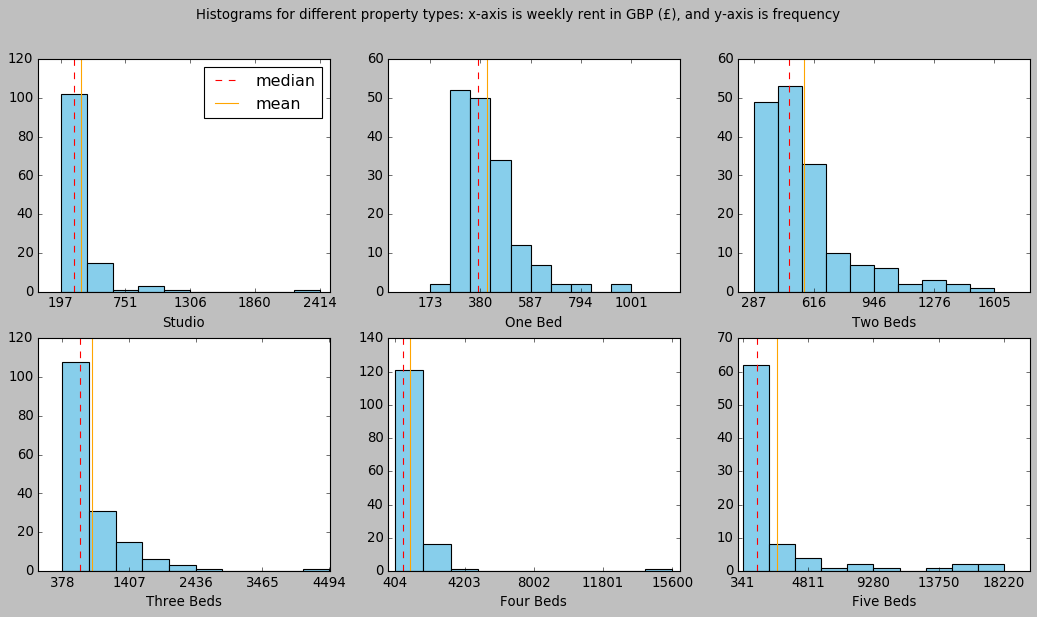

In [9]:
columns = df_rent.columns.values.tolist()[1:-1]
fig = plt.figure(figsize = (16,8))
plt.suptitle('Histograms for different property types: x-axis is weekly rent in GBP (£), and y-axis is frequency')
for index,column in enumerate(columns):
    fig.add_subplot(2,3,index+1)
    df_temp = df_rent[column]
    df_temp.dropna(axis = 0,inplace = True)
    plt.hist(df_temp,color = 'skyblue')
    plt.axvline(x = df_temp.median(),linestyle = '--',color = 'r')
    plt.axvline(x = df_temp.mean(),linestyle = '-',color = 'orange')
    plt.xticks(np.linspace(df_temp.min(),df_temp.max(),5))
    if index == 0:
        plt.legend(['median','mean'])
    plt.xlabel(column)

Seeing as for for the most part, the median seems to be more reliable... it was decidecd to replace the np.nan values with the median!

In an ideal case, one would first, as part of the preprocessing, ensure that neighbourhoods are first clustered by the average property prices (i.e. cheaper ones would be clustered together, more expensive ones in another cluster, then for each cluster, the median will be used to fill that certain cluster). This would be interesting to add for the next iteration of this project.

In [48]:
for i, column in enumerate(columns):
    df_rent[column] = df_rent[column].fillna(df_rent[column].median())
    
print(df_rent.shape)
df_rent.head()

(174, 8)


,Place,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,PostDist
0,Bromley,313.0,263.0,287.0,381.0,498.0,1300.0,BR1
1,Croyon,197.0,280.0,355.0,654.0,803.0,1300.0,CR0
2,Bethnal Green,292.0,370.0,461.0,583.0,622.0,1300.0,E2
3,Bow,313.0,313.0,371.0,481.0,612.0,637.0,E3
4,Canary Wharf,405.0,507.0,585.0,719.0,803.0,1300.0,E14


## Finding close supermarkets, restaurants and nightlife

In [132]:
# path to .json file containing Foursquare credentials

path = ("/Users/yousefnami/Desktop/Yousef/PrivateTings/MyStuff/"
        "Courses/IBMDataScienceCertificate/CapstoneProject/Capstone/Coursera_Capstone/config.json")

with open(path, 'r') as f:
    config = json.load(f)

# configure the foursquare API rules
CID = config['foursquare']['CID']
CSecret = config['foursquare']['CSecret']
CategoryID = '4d4b7105d754a06374d81259'
version = '20180604'
limit = 50 # maximum limit allowed by foursquare [1]
latitude = '50'
longitude = '-0.1'

# setting up a query for formatting the foursquare URL
query = {
    'CID':CID,
    'CSecret':CSecret,
    'CategoryID':CategoryID,
    'version': version,
    'limit':limit,
    'lat':latitude,
    'long':longitude
}

# categories that we are interested in searching, with their correct foursquare ID's [2]
categories = {
    'restaurants':'4d4b7105d754a06374d81259',
    'grocery': '4bf58dd8d48988d1f9941735',
    'nightlife': '4d4b7105d754a06376d81259',
    'entertainment': '4d4b7104d754a06370d81259',
    'outdoors': '4d4b7105d754a06377d81259'
}

# testing that everything works
url = ('https://api.foursquare.com/v2/venues/search?client_id={CID}'
       '&client_secret={CSecret}'
       '&categoryId={CategoryID}'
       '&ll={lat},{long}'
       '&v={version}'
       '&limit={limit}'
      )

url_test = url.format(**query)

https://api.foursquare.com/v2/venues/search?client_id=FMCDZPYONFVHEFJII12MQ0RD0EO0IKTYUXKP1KDHET3EHAGT&client_secret=RWOWC0OKANY2DGVAY0HEWMWTQFSIAUWXMXWF3YR5IQEZQZIJ&categoryId=4d4b7105d754a06374d81259&ll=50,-0.1&v=20180604&limit=50
{'meta': {'code': 200, 'requestId': '5f70b8353ad6f205dfc1cd62'}, 'response': {'venues': []}}


In [318]:
#ideally, you should convert all of these into a class ! 

def plot_map(lat_long,geojson_path):
    m = folium.Map(
        location = lat_long, # must be a list
        zoom_start = 11
    )
    folium.GeoJson(
    geojson_path,
    name='geojson'
    ).add_to(m)
    
    return m

def add_labels(geolocator, m, address_list, address_global = ''):
    for index, address in enumerate(address_list):
        try:
            
            lat_long = get_lat_long(geolocator, address+', {}'.format(address_global))
            if lat_long != None:
                folium.Marker(
                    location = lat_long
                ).add_to(m)
        except:
            pass

        print(index/len(address_list))
    return m
    
def get_lat_long(geolocator,address):
    # note, geolocator must be defined before

    location = geolocator.geocode(address)
    return [location.latitude, location.longitude]

# note that the above, using NOMINATIM as a geocoder is terrible !

def add_labels1(geolocator, m, address_list, locality, country):
    for index, address in enumerate(address_list):
        print(address+locality+country)


        lat_long = get_lat_long1(geolocator, address, locality, country)
        if lat_long != None:
            
            folium.Marker(
                location = lat_long
            ).add_to(m)
    return m
    
def get_lat_long1(geolocator,address,locality,country):
    # note, geolocator must be defined before

    try:
        location = geolocator.geocode(query=address, components = {'country':country,"locality":locality})
    except:
        pass
    if location != None:
        return [location.latitude, location.longitude]
    else:
        return None





In [319]:
#geolocator = Nominatim(user_agent="foursquare_agent") DONT USE!

# london geodata {from source:[3]}
path = ("/Users/yousefnami/Desktop/Yousef/PrivateTings/MyStuff/"
        "Courses/IBMDataScienceCertificate/CapstoneProject/Capstone/Coursera_Capstone/Data/london_geodata.json")

geolocator = GoogleV3(config['google']['key'])

lat_long = get_lat_long(geolocator, 'London, United Kingdom')
m = plot_map(lat_long, path)
#m = add_labels(geolocator, m, df_rent.PostDist.unique().tolist(), address_global = 'London, England, United Kingdom')
m = add_labels1(geolocator, m, df_rent.PostDist.unique().tolist(), 'London','United Kingdom')


# add imperial college
lat_long = get_lat_long(geolocator, 'Imperial College London')
folium.Marker(
    location = lat_long,
    icon=folium.Icon(color='red') 
).add_to(m)
m

BR1LondonUnited Kingdom
Bromley BR1, UK
0.0
CR0LondonUnited Kingdom
Croydon CR0, UK
0.009433962264150943
E2LondonUnited Kingdom
London E2, UK
0.018867924528301886
E3LondonUnited Kingdom
London E3, UK
0.02830188679245283
E14LondonUnited Kingdom
London E14, UK
0.03773584905660377
E16LondonUnited Kingdom
London E16, UK
0.04716981132075472
E8LondonUnited Kingdom
London E8, UK
0.05660377358490566
E1LondonUnited Kingdom
London E1, UK
0.0660377358490566
E15LondonUnited Kingdom
London E15, UK
0.07547169811320754
E17LondonUnited Kingdom
Walthamstow, London, UK
0.08490566037735849
E11LondonUnited Kingdom
London E11, UK
0.09433962264150944
E1WLondonUnited Kingdom
London E1W, UK
0.10377358490566038
EC1VLondonUnited Kingdom
London EC1V, UK
0.11320754716981132
EC3LondonUnited Kingdom
EC2YLondonUnited Kingdom
London EC2Y, UK
0.1320754716981132
EC4VLondonUnited Kingdom
London EC4V, UK
0.14150943396226415
EC1MLondonUnited Kingdom
London EC1M, UK
0.1509433962264151
EC4RLondonUnited Kingdom
London EC4R, 

Note that some of the postcodes in our dataset are actually outside what would be considered 'London' (and thus maybe as part of greater London). The data set also does not cover some major locations, as shown by the map. Unfortunately, there isn't much in our power to improve this!

That said though, I will continue the project for now (as this is the 'first' iteration). Future improvements should look into scraping data from websites such as 'rightmove.com'.

In [ ]:
""" ONLY RUN THIS CELL WHEN NECESSARY TO CONSERVE API CALLS! """
all_venues = dict.fromkeys(
    df_rent.PostDist.unique().tolist()
)


for postal_district in df_rent.PostDist.unique():
    location = geolocator.geocode('{}, London, England, United Kingdom'.format(postal_district))
    latitude = location.latitude
    longitude = location.longitude
    query['lat'] = latitude
    query['long'] = longitude
    all_venues[postal_district] = dict.fromkeys(
        categories.keys()    
    )
    for category, item in categories.items():
        
        query['CategoryID'] = item
        url_temp = url.format(**query)
        results = requests.get(url_temp).json()
        dict_temp = {category: results}
        all_venues[postal_district].update(dict_temp)
        #results = requests.get(url_temp).json()
        #df_temp = json_normalize(results)
        #dict_temp = {postal_district: df_temp}
        #all_venues.update(dict_temp)

In [175]:
dfs = []
for postal_district in df_rent.PostDist.unique():
    for category, item in categories.items():
        print(all_venues[postal_district][category])
    break
df_temp.head()

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f70bfa2eb6bac0a34dd9b3a'}, 'response': {}}
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f70bfa220170e30daf936f1'}, 'response': {}}
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f70bfa2f6659d6eef5bc3b6'}, 'response': {}}
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f70bfa3ecbf7e4afaf49dda'}, 'response': {}}
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f70bfa41506b90ebd9175c3'}, 'response': {}}


,meta.code,meta.requestId,response.venues,response.confident
0,200,5f70bc5bcf0cb93038f76d59,"[{'id': '502904745dd7750e9d63bc17', 'name': 'S...",False


## Finding closeness to university using Google Maps API

In [220]:
# configure the Google Directions API rules

key = config['google']['key']

origin = 'SW7+3BQ+London+England' # where you start from (this would be the postcode district!)

destination = 'Imperial College London London United Kingdom'
destination = destination.replace(' ','+') # where you want to end up, note '+' added for Google API requirements

mode = 'bicycling' # can also be 'walking' or 'transit'

transit_mode = 'bus' # can also be 'subway'

# setting up a query for formatting the foursquare URL
query = {
    'key':key,
    'origin':origin,
    'destination': destination,
    'mode': mode
}

# testing that everything works
url = ('https://maps.googleapis.com/maps/api/directions/json?key={key}'
       '&origin={origin}'
       '&destination={destination}'
       '&mode={mode}'
      )

# if mode == transit, then: url +  '&transit_mode={transit_mode}'

url_test = url.format(**query)


modes = {
    'walking':'walking', 
    'bicycling':'bicycling',
    'transit': ['bus','subway']
}


In [276]:
all_directions = dict.fromkeys(
    df_rent.PostDist.unique().tolist()
)

for postal_district in df_rent.PostDist.unique():
    
    all_directions[postal_district] = dict.fromkeys(
        list(modes.values())[:-1] + modes['transit']
    )
    query['origin'] = '{}+London+United+Kingdom'.format(postal_district)
    for mode, item in modes.items():
        query['mode'] = mode

        if mode == 'transit':
            for transit_type in item:
                url_temp = url.format(**query) + '&transit_mode={}'.format(transit_type)
                results = requests.get(url_temp).json()
                dict_temp = {transit_type: results}
                all_directions[postal_district].update(dict_temp)
        else:
            url_temp = url.format(**query)   
            results = requests.get(url_temp).json()
            dict_temp = {mode: results}
            all_directions[postal_district].update(dict_temp)

In [285]:
# retrieve important information 
# let's try multi index pandas tables !
post_dists = []
trans_mode = []
duration = []
for post_dist in df_rent.PostDist.unique():
    
    for item in list(modes.values())[:-1] + modes['transit']:
        post_dists.append(post_dist)
        trans_mode.append(item)
        duration.append(all_directions[post_dist][item]['routes'][0]['legs'][0]['duration']['value'])
        


        
index_tuples = list(zip(post_dists, trans_mode))
index = pd.MultiIndex.from_tuples(index_tuples, names=['PostDist', 'TransportMode'])
df_travel = pd.DataFrame(data={'duration':duration},index = index)

df_travel.head()





duration
PostDist TransportMode          
BR1      walking           14921
         bicycling          4474
         bus                5985
         subway             3772
CR0      walking           11946

In [ ]:
df_travel.to_csv()

# Conclusion

# References

1. https://stackoverflow.com/questions/45992235/foursquare-api-get-filtered-list-of-restaurants
2. https://developer.foursquare.com/docs/build-with-foursquare/categories/
3. https://github.com/sjwhitworth/london_geojson/blob/master/london_postcodes.json


